<a href="https://colab.research.google.com/github/LelyshB/Car_price_predict/blob/main/Car_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1gSobTzFm74pf_hTHZBPoGJOjL32BEFSQ/view?usp=sharing

In [ ]:
pip install --upgrade gdown

In [ ]:
! gdown 1gSobTzFm74pf_hTHZBPoGJOjL32BEFSQ

Downloading...
From: https://drive.google.com/uc?id=1gSobTzFm74pf_hTHZBPoGJOjL32BEFSQ
To: /content/carprice.zip
100% 1.15M/1.15M [00:00<00:00, 97.9MB/s]


In [ ]:
! unzip /content/carprice.zip

Archive:  /content/carprice.zip
replace audi.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: audi.csv                
  inflating: bmw.csv                 
  inflating: cclass.csv              
  inflating: focus.csv               
  inflating: ford.csv                
  inflating: hyundi.csv              
  inflating: merc.csv                
  inflating: skoda.csv               
  inflating: toyota.csv              
  inflating: unclean cclass.csv      
  inflating: unclean focus.csv       
  inflating: vauxhall.csv            
  inflating: vw.csv                  


In [ ]:
! pip install shap

In [ ]:
pip install catboost

In [ ]:
# Основные библиотеки для обработки данных
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Модели машинного обучения
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, adjusted_rand_score, mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from joblib import dump, load

import shap
from scipy import stats

In [ ]:
df = pd.read_csv('/content/ford.csv')

# Знакомство с данным

In [ ]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


In [ ]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000
mean,2016.866574,12279.756415,23363.630504,113.334539,57.906991,1.350827
std,2.050346,4741.382606,19472.114690,62.010438,10.125977,0.432371
min,1996.000000,495.000000,1.000000,0.000000,20.800000,0.000000
25%,2016.000000,8999.000000,9987.000000,30.000000,52.300000,1.000000
50%,2017.000000,11291.000000,18243.000000,145.000000,58.900000,1.200000
75%,2018.000000,15299.000000,31064.000000,145.000000,65.700000,1.500000
max,2060.000000,54995.000000,177644.000000,580.000000,201.800000,5.000000


In [ ]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

# Проверка корреляций в данных

<ipython-input-11-91ab4c9edd27>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

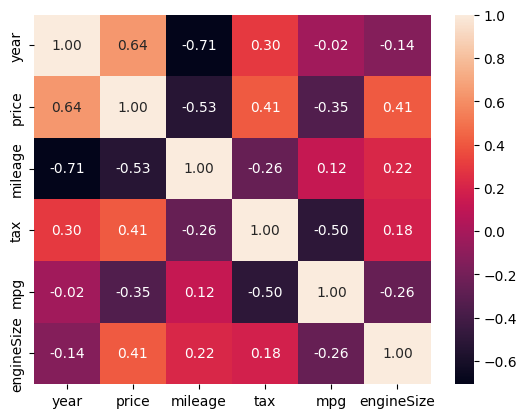

In [ ]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")

# Создаем дополнительные фичи

In [ ]:
model_mean_price = df.groupby('model')['price'].mean().reset_index()
model_mean_price.columns = ['model', 'model_mean_price']

df = pd.merge(df, model_mean_price, on='model', how='left')

In [ ]:
mean_price_by_year = df.groupby('year')['price'].mean().reset_index()
mean_price_by_year.columns = ['year', 'mean_price_by_year']

df = pd.merge(df, mean_price_by_year, on='year', how='left')

In [ ]:
df.sample(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,model_mean_price,mean_price_by_year
3042,Ka+,2017,7440,Manual,5380,Petrol,145,57.7,1.2,8707.856874,11965.689853
5135,Mondeo,2017,12791,Manual,29252,Diesel,150,65.7,2.0,12305.709125,11965.689853
6205,Edge,2019,29999,Semi-Auto,7999,Diesel,145,37.2,2.0,22810.500000,17176.449280
11822,Fiesta,2019,16099,Semi-Auto,7374,Petrol,145,48.7,1.0,10196.298002,17176.449280
1568,Fiesta,2018,10695,Manual,8151,Petrol,150,58.9,1.0,10196.298002,13157.894619


# **Cross Validation**

In [ ]:
X = df.drop(['price','model','transmission','fuelType'], axis=1)
y = df['price']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
models = [
    LinearRegression(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Mean MSE', 'Std MSE', 'Mean MAE', 'Std MAE', 'Mean R^2', 'Std R^2'])

In [ ]:
for model in models:
    mse_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    mean_mse = -mse_scores.mean()
    std_mse = mse_scores.std()

    mae_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
    mean_mae = -mae_scores.mean()
    std_mae = mae_scores.std()

    r2_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    mean_r2 = r2_scores.mean()
    std_r2 = r2_scores.std()

    results_df = results_df.append({'Model': model.__class__.__name__,
                                    'Mean MSE': mean_mse,
                                    'Std MSE': std_mse,
                                    'Mean MAE': mean_mae,
                                    'Std MAE': std_mae,
                                    'Mean R^2': mean_r2,
                                    'Std R^2': std_r2}, ignore_index=True)

<ipython-input-19-c4de64be5a9b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model.__class__.__name__,
<ipython-input-19-c4de64be5a9b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model.__class__.__name__,
<ipython-input-19-c4de64be5a9b>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model.__class__.__name__,


In [ ]:
results_df

,Model,Mean MSE,Std MSE,Mean MAE,Std MAE,Mean R^2,Std R^2
0,LinearRegression,3.507247e+06,492415.882427,1373.484988,51.737287,0.838373,0.008365
1,RandomForestRegressor,1.692222e+06,273941.453789,907.399270,47.723946,0.921751,0.003198
2,GradientBoostingRegressor,1.801855e+06,376745.194153,948.040009,57.495782,0.917573,0.007319


**Случайный лес оказался наилучшим вариантом, поэтому фитим в него всю выборку**

In [ ]:
train, test = train_test_split(df,train_size=0.8,random_state=42)

In [ ]:
X_train = train.drop(['price','model','fuelType','transmission'], axis=1)
y_train = train['price']

X_test = test.drop(['price','model','fuelType','transmission'], axis=1)
y_test = test['price']

In [ ]:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 1559946.770500699
Mean Absolute Error (MAE): 862.0661677257631
R^2 Score: 0.9302920979903176


# **Catboost**

In [ ]:
train, test = train_test_split(df,train_size=0.6,random_state=42)

val, test = train_test_split(test,train_size=0.5,random_state=42)

In [ ]:
X = ['model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize','model_mean_price','mean_price_by_year']

cat_features = ['model', 'transmission', 'fuelType']

y = ['price']

In [ ]:
parameters = {'cat_features': cat_features,
              'eval_metric': 'MAPE',
              'learning_rate': 0.08,
              'random_seed':42,
              'verbose':100}

In [ ]:
model = CatBoostRegressor(**parameters)

In [ ]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.3637301	test: 0.3654584	best: 0.3654584 (0)	total: 57.6ms	remaining: 57.5s
100:	learn: 0.0765640	test: 0.0778798	best: 0.0778798 (100)	total: 892ms	remaining: 7.94s
200:	learn: 0.0700984	test: 0.0722594	best: 0.0722594 (200)	total: 1.7s	remaining: 6.77s
300:	learn: 0.0672083	test: 0.0703758	best: 0.0703758 (300)	total: 2.67s	remaining: 6.21s
400:	learn: 0.0654854	test: 0.0694980	best: 0.0694980 (400)	total: 4.29s	remaining: 6.41s
500:	learn: 0.0641917	test: 0.0688890	best: 0.0688890 (500)	total: 5.1s	remaining: 5.08s
600:	learn: 0.0629860	test: 0.0684509	best: 0.0684477 (599)	total: 5.9s	remaining: 3.92s
700:	learn: 0.0620846	test: 0.0680947	best: 0.0680947 (700)	total: 6.7s	remaining: 2.85s
800:	learn: 0.0612913	test: 0.0678909	best: 0.0678865 (798)	total: 7.49s	remaining: 1.86s
900:	learn: 0.0606597	test: 0.0677393	best: 0.0677393 (900)	total: 8.28s	remaining: 910ms
999:	learn: 0.0600115	test: 0.0675680	best: 0.0675639 (993)	total: 9.09s	remaining: 0us

bestTest = 0.06756

In [ ]:
test['price_pred'] = model.predict(test[X])

In [ ]:
def error(y_true,y_pred):
  print('"Mean Squared Error (MSE):"',mean_squared_error(y_true,y_pred))
  print('"Mean Squared Error (MAE):"',mean_absolute_error(y_true,y_pred))
  print('"R^2 score:"',r2_score(y_true, y_pred))

error(test['price'],test['price_pred'])

"Mean Squared Error (MSE):" 1229372.4615310512
"Mean Squared Error (MAE):" 804.9357945332318
"R^2 score:" 0.9462597505334905


Посмотрим качество модели на графике

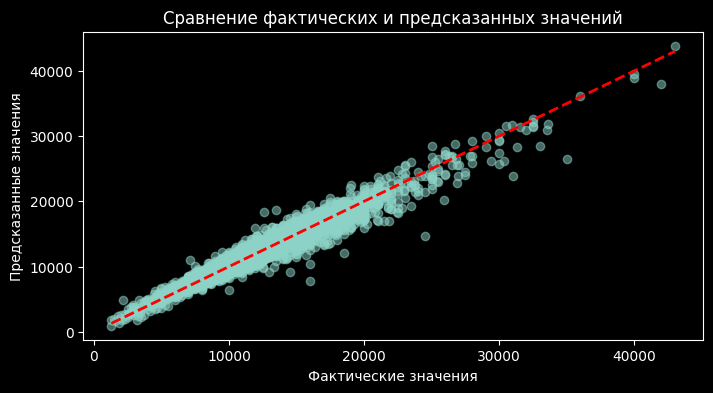

In [ ]:
plt.figure(figsize=(8, 4))
plt.style.use('dark_background')

plt.scatter(test['price'], test['price_pred'], alpha=0.5)
plt.plot([min(test['price']), max(test['price'])], [min(test['price']), max(test['price'])], '--r', linewidth=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.show()

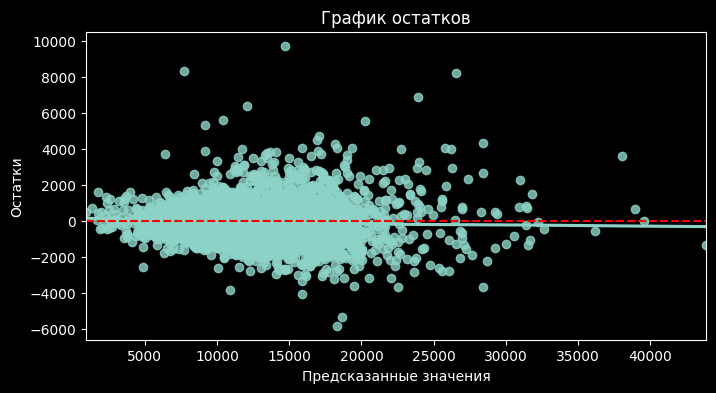

In [ ]:
residuals = test['price'] - test['price_pred']

plt.figure(figsize=(8, 4))
sns.residplot(x=test['price_pred'], y=residuals, lowess=True)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

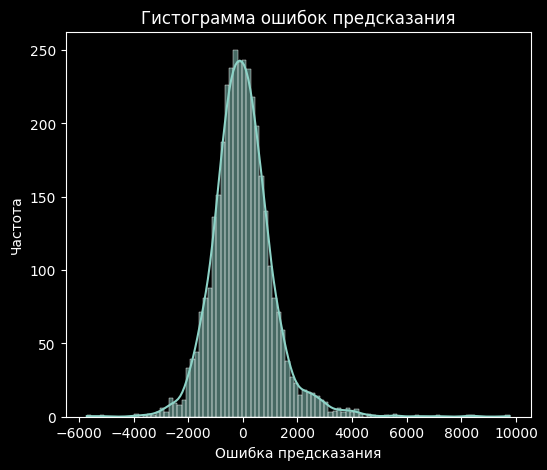

In [ ]:
# Гистограмма ошибок
plt.figure(figsize=(6, 5))
sns.histplot(residuals, kde=True)
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Гистограмма ошибок предсказания')
plt.show()

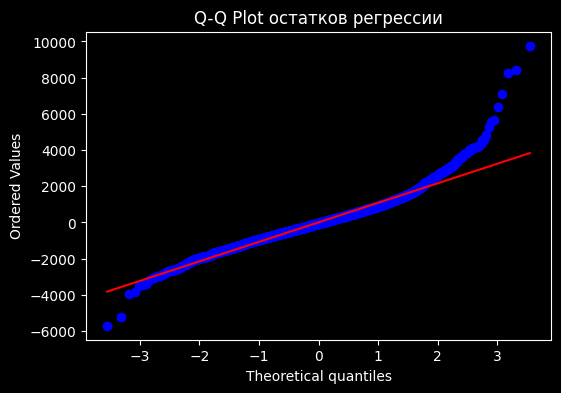

In [ ]:
# Q-Q Plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot остатков регрессии')
plt.show()

На графиках чётко видно, что модель хорошо справляется с большинством автомобилей,
но допускает много ошибок при предсказании дорогих авто

In [ ]:
feature_importances = random_forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

cm = sns.dark_palette("blue", as_cmap=True)
feature_importance_df.style.background_gradient(cmap=cm,subset='Importance')

,Feature,Importance
6,mean_price_by_year,0.352952
4,engineSize,0.219003
5,model_mean_price,0.168270
0,year,0.125565
1,mileage,0.074031
3,mpg,0.050598
2,tax,0.009580


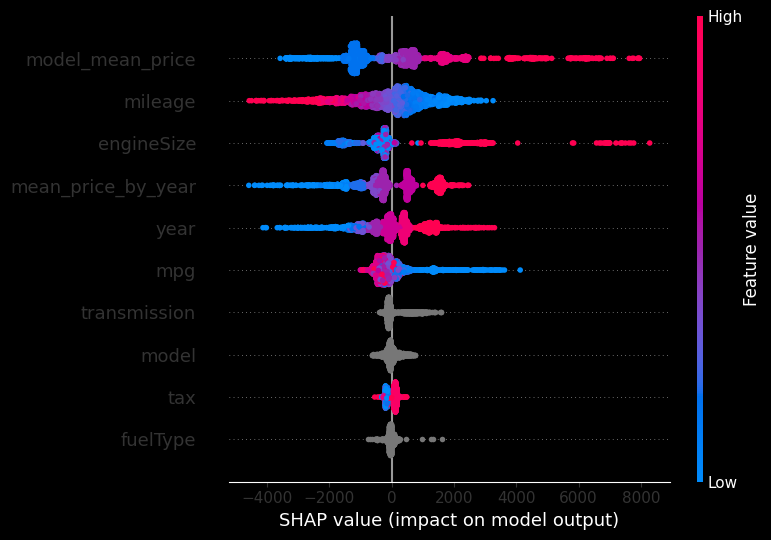

In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(val[X])

shap.summary_plot(shap_values, val[X])

У модели хорошие показатели, поэтому оставляем её и сохраняем

# **Сохранение**

In [ ]:
dump(model, 'model.joblib')
model = load('model.joblib')